## **4. Keywords Clustering** (sklearn)

https://colab.research.google.com/drive/1HHNFjKlip1AaFIuvvn0AicWyv6egLOZw?usp=sharing#scrollTo=zhP1daroRzRV  
(Une approche à base de Word embedding - on pourrait utiliser les scores TF-IDF ou OKapi pour les traits discriminants plutôt que la fréquence (voir plus bas))

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn import metrics
import matplotlib.pyplot as plt

Importer la liste de termes candidats avec leur fréquence

In [2]:
path = '../05-transformation/'
acteur = 'msss'

csv_file = acteur + '_weighting_OKapiBM25.csv'

In [3]:
from pandas import *

with open(path+csv_file, encoding='utf-8') as f:
    keywords = read_csv(f).drop(columns = ['Unnamed: 0'])[['Terme', 'Fréquence (TF)', 'Fréquence documentaire (DF)']]
    keywords['TF + DF']= keywords['Fréquence (TF)'] + keywords['Fréquence documentaire (DF)']
keywords

,Terme,Fréquence (TF),Fréquence documentaire (DF),TF + DF
0,différence entre le tarif horaire de l'eésad,79,79,158
1,croissance,115,111,226
2,chapitre s-4.2,34,25,59
3,sexe de l'usager identifiant de la demande,16,16,32
4,québec (fmoq),33,15,48
...,...,...,...,...
15581,entretien coût,28,1,29
15582,montérégie-ouest,111,79,190
15583,acquisition coûts de service mensuels,28,1,29
15584,milieux de vie pour aînés,31,27,58


In [4]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer("(\w+\'|\w+-\w+|\(|\)|\w+)")

file_path = "../04-filtrage/stopwords.txt"
with open(file_path, 'r', encoding="utf-8") as f:
    stopwords = [t.lower().strip('\n') for t in f.readlines()]

def to_tokens(kw, min_chars=2):
    """
    Transforms sentence to list of tokens.  

    Basic: transform special characters to ascii + lowercase.  
    Options:  
    - remove stopwords (provide list of stopwords)  
    - set minimum length for tokens: will remove any shorter token. 
    
    Returns sorted tokens
    """
    tokens = tokenizer.tokenize(kw) # split the string into a list of words
    tokens = [word for word in tokens if len(word) > min_chars] 
    tokens = [word for word in tokens if word not in stopwords] 
    
    tokens = set(tokens) # to remove duplicates
    tokens = sorted(tokens) # converts our set back to a list and sorts words in alphabetical order
    return tokens

In [5]:
keywords["tokens"] = keywords["Terme"].apply(lambda x: to_tokens(
    x,
    min_chars=2,
))

## Test - ça fait pas beaucoup de sens de cluster des unigrammes, on va donc seulement retenir des n-grammes où n est au-dessus de 2
keywords["len"] = keywords["tokens"].apply(lambda x : len(x))
keywords = keywords[keywords['len'] > 1].drop(columns=["len"])

In [6]:
keywords

,Terme,Fréquence (TF),Fréquence documentaire (DF),TF + DF,tokens
0,différence entre le tarif horaire de l'eésad,79,79,158,"[différence, eésad, horaire, tarif]"
2,chapitre s-4.2,34,25,59,"[chapitre, s-4]"
3,sexe de l'usager identifiant de la demande,16,16,32,"[demande, identifiant, sexe, usager]"
4,québec (fmoq),33,15,48,"[fmoq, québec]"
5,surveillance des maladies d'intérêt,19,19,38,"[intérêt, maladies, surveillance]"
...,...,...,...,...,...
15580,heures de service de soutien à domicile de cou...,63,58,121,"[courte, domicile, durée, heures, service, sou..."
15581,entretien coût,28,1,29,"[coût, entretien]"
15583,acquisition coûts de service mensuels,28,1,29,"[acquisition, coûts, mensuels, service]"
15584,milieux de vie pour aînés,31,27,58,"[aînés, milieux, vie]"


In [7]:
from collections import Counter

vocab = sorted(set(keywords["tokens"].explode()))
len(vocab)

counter = Counter(keywords["tokens"].explode().to_list())
vocab = []

# Ici, ça serait intéressant de retenir sur la base du score TF-IDF ou OKapi
for key,value in counter.most_common(50):
    vocab.append(key)
len(vocab)

50

In [8]:
def to_vector(keyword,vocab):
    """
    Calculates vector of keyword on given vocabulary.

    Returns vector as a list of values.  
    """
    vector = []
    for word in vocab:
        if word in keyword:
            vector.append(1)
        else:
            vector.append(0)
    return vector

# Remarque : le type d'embedding qui est fait ici est du style 'One-hot encoding (binaire - si le terme est présent = 1, sinon 0) ; mais il existe d'autres manière de 
# représenter la matrice de cooccurrences qu'avec des scores binaires
keywords["vector"] = keywords["tokens"].apply(lambda x: to_vector(x,vocab))
keywords

,Terme,Fréquence (TF),Fréquence documentaire (DF),TF + DF,tokens,vector
0,différence entre le tarif horaire de l'eésad,79,79,158,"[différence, eésad, horaire, tarif]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,chapitre s-4.2,34,25,59,"[chapitre, s-4]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,sexe de l'usager identifiant de la demande,16,16,32,"[demande, identifiant, sexe, usager]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,québec (fmoq),33,15,48,"[fmoq, québec]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,surveillance des maladies d'intérêt,19,19,38,"[intérêt, maladies, surveillance]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
15580,heures de service de soutien à domicile de cou...,63,58,121,"[courte, domicile, durée, heures, service, sou...","[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, ..."
15581,entretien coût,28,1,29,"[coût, entretien]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
15583,acquisition coûts de service mensuels,28,1,29,"[acquisition, coûts, mensuels, service]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
15584,milieux de vie pour aînés,31,27,58,"[aînés, milieux, vie]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [52]:
# On pourrait par exemple utiliser un modèle BERT/sentence transformers (fr) pour extraire nos embeddings plutôt que des simples one-hot encoding
# from sentence_transformers import SentenceTransformer
# model =  SentenceTransformer("dangvantuan/sentence-camembert-large")

In [53]:
#sentences = keywords['Terme'].tolist()
#embeddings = model.encode(sentences)

#### **K-means clustering** (*sklearn*)
(one hot embedding ; trying with sentence transformers but too long)

Méthode Elbow


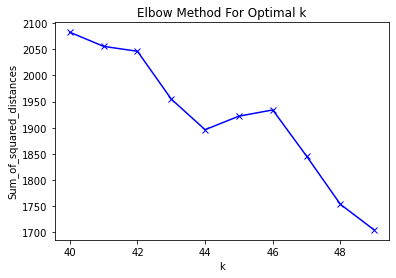

Score Silhouette
On va regrouper nos termes en 49 clusters.


,Nombre de clusters (k),Score Silhouette
0,40,0.777001
1,41,0.771993
2,42,0.800488
3,43,0.793277
4,44,0.796104
5,45,0.797483
6,46,0.803839
7,47,0.806219
8,48,0.802264
9,49,0.808612


In [54]:
K = range(40,50)
Sum_of_squared_distances = []
silhouette_scores = []

for k in K:
    #true_k = int(input())
    X = keywords["vector"].to_list()
    kmeans = KMeans(n_clusters=k, init='k-means++', algorithm='elkan', max_iter=200, n_init=1).fit(X)
    Sum_of_squared_distances.append(kmeans.inertia_)

    # Run LSA
    # Since LSA/SVD results are not normalized,
    # we redo the normalization to improve the k-means result.
    svd = TruncatedSVD(n_components=k)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)
    kmeans.fit(X)

    labels = kmeans.labels_
    #keywords["Cluster"] = list(kmeans.labels_)

    original_space_centroids = svd.inverse_transform(X)
    order_centroids = original_space_centroids.argsort()[:, ::-1]
    silhouette_scores.append([k, metrics.silhouette_score(X, labels)])

df = DataFrame(silhouette_scores, columns=['Nombre de clusters (k)', 'Score Silhouette'])
true_k = int(df[df['Score Silhouette'] == df['Score Silhouette'].max()]['Nombre de clusters (k)'])

print("Méthode Elbow")
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

print("Score Silhouette")
print("On va regrouper nos termes en " + str(true_k) + " clusters.")
df

In [59]:
X = keywords["vector"].to_list()
kmeans = KMeans(n_clusters=true_k, init='k-means++', algorithm='elkan', max_iter=200, n_init=1).fit(X)

# Run LSA
# Since LSA/SVD results are not normalized,
# we redo the normalization to improve the k-means result.
svd = TruncatedSVD(n_components=true_k)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(X)
kmeans.fit(X)

labels = kmeans.labels_
keywords["kmeans"] = list(kmeans.labels_)

keywords


,Terme,Fréquence (TF),Fréquence documentaire (DF),TF + DF,tokens,vector,kmeans
0,différence entre le tarif horaire de l'eésad,79,79,158,"[différence, eésad, horaire, tarif]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
2,chapitre s-4.2,34,25,59,"[chapitre, s-4]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
3,sexe de l'usager identifiant de la demande,16,16,32,"[demande, identifiant, sexe, usager]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",35
4,québec (fmoq),33,15,48,"[fmoq, québec]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8
5,surveillance des maladies d'intérêt,19,19,38,"[intérêt, maladies, surveillance]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
...,...,...,...,...,...,...,...
15580,heures de service de soutien à domicile de cou...,63,58,121,"[courte, domicile, durée, heures, service, sou...","[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, ...",32
15581,entretien coût,28,1,29,"[coût, entretien]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
15583,acquisition coûts de service mensuels,28,1,29,"[acquisition, coûts, mensuels, service]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",11
15584,milieux de vie pour aînés,31,27,58,"[aînés, milieux, vie]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",26


Apposer un label approprié aux cluster

In [22]:
# keywords.to_csv('../06-clustering/' + acteur + '_clusters-K-means.csv')

In [66]:
current_labels = set(kmeans.labels_.tolist())

desired_labels = {x : None for x in current_labels} # (on initialise à None)

for label in current_labels:
    cluster = keywords[keywords["kmeans"] == label]
    max_freq = cluster['TF + DF'].max()
    new_label = cluster[cluster['TF + DF'] == max_freq]['Terme'].values[0]

    desired_labels[label] = new_label

keywords['Cluster'] = keywords['kmeans'].map(desired_labels)

In [67]:
#keywords = keywords[['Terme', 'Fréquence (TF)', 'Fréquence documentaire (DF)', 'Cluster']]
keywords.sort_values(["Cluster"], 
        axis=0,
        ascending=[False], 
        inplace=True)

In [68]:
keywords

,Terme,Fréquence (TF),Fréquence documentaire (DF),TF + DF,tokens,vector,kmeans,Cluster
15144,évaluation des besoins,41,40,81,"[besoins, évaluation]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",28,évaluation à jour
10835,durée ayant une évaluation,214,158,372,"[durée, évaluation]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",28,évaluation à jour
13898,évaluation de la qualité,79,67,146,"[qualité, évaluation]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",28,évaluation à jour
4039,délai moyen d'attente à l'évaluation,52,45,97,"[attente, délai, moyen, évaluation]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",28,évaluation à jour
141,chsld public ayant une évaluation à jour,45,45,90,"[chsld, jour, public, évaluation]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",28,évaluation à jour
...,...,...,...,...,...,...,...,...
206,accès à la mammographie,19,19,38,"[accès, mammographie]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",30,accès aux services
14550,accès à l'hébergement du cisss,24,8,32,"[accès, cisss, hébergement]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",30,accès aux services
2847,respect d'accès,20,20,40,"[accès, respect]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",30,accès aux services
11506,accès à du matériel,19,19,38,"[accès, matériel]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",30,accès aux services


In [69]:
keywords.groupby("Cluster")["Terme"].count()

Cluster
accès aux services                         108
aide domestique                             56
année financière                           108
besoins de l'usager                         80
cadre de référence                         116
cas confirmés                               79
centre hospitalier                         124
centres d'hébergement                       66
cours de l'année                            81
disponibilité des données                  258
domicile longue durée                       89
doses de vaccin                            139
déficience intellectuelle                   81
enfants âgés                                51
gouvernement du québec                     209
heures de service                           97
indicateurs de gestion                      85
jeunes en difficulté                        65
mesures à prendre                           80
milieu de vie                               92
ministère de la santé                      360
minis

---------------  
Visualisation 
--------------  

In [70]:
from sklearn.decomposition import PCA

vectors = keywords["vector"].to_list()

pca = PCA(n_components=2).fit(vectors)
pca_2d = pca.transform(vectors)

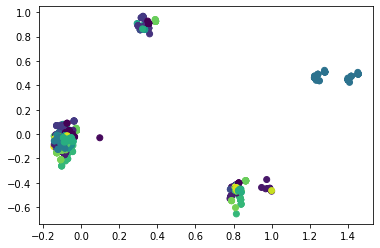

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(pca_2d[:,0], pca_2d[:,1], c=keywords["kmeans"])

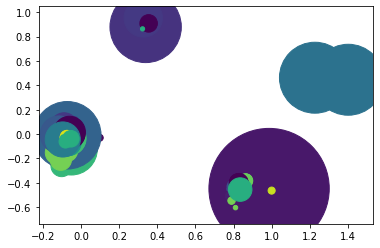

In [72]:
plt.scatter(pca_2d[:,0], pca_2d[:,1], c=keywords["kmeans"], s=keywords["Fréquence (TF)"])

In [73]:
from collections import Counter

counter = Counter(keywords["tokens"].explode().to_list())
vocab = []
for key,value in counter.most_common(100):
    vocab.append(key)
len(vocab)

100

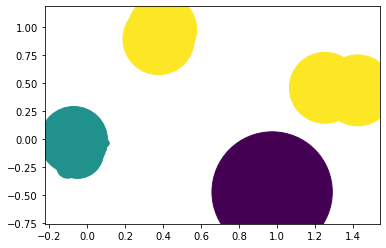

In [74]:
keywords["vector"] = keywords["tokens"].apply(lambda x: to_vector(x,vocab))
pca = PCA(n_components=2).fit(keywords["vector"].to_list())
pca_2d = pca.transform(keywords["vector"].to_list())

kmeans = KMeans(n_clusters = 3, random_state=0).fit(keywords["vector"].to_list())
keywords["kmeans"] = list(kmeans.labels_)

plt.scatter(pca_2d[:,0], pca_2d[:,1], c=keywords["kmeans"], s=keywords["Fréquence (TF)"])

### **K-means clustering** (*NLTK*)
(+Word2Vec embedings)

In [9]:
from nltk.cluster import KMeansClusterer
import nltk
import numpy as np 
  
from sklearn import cluster
from sklearn import metrics

In [14]:
X = keywords["vector"].to_list()

Reprendre ici, je pense qu'il accepte pas le format de mes vecteurs

In [15]:
# Distance cosinus
kclusterer = KMeansClusterer(10, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
print (assigned_clusters)

TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [13]:

  
  
  
for index, sentence in enumerate(keywords['Terme'].tolist()):    
    print (str(assigned_clusters[index]) + ":" + str(sentence))




# Run LSA
# Since LSA/SVD results are not normalized,
# we redo the normalization to improve the k-means result.
# svd = TruncatedSVD(n_components=k)
# normalizer = Normalizer(copy=False)
# lsa = make_pipeline(svd, normalizer)

#X = lsa.fit_transform(X)
kmeans.fit(X)

/Users/camilledemers/opt/anaconda3/lib/python3.9/site-packages/nltk/cluster/util.py:130: RuntimeWarning: invalid value encountered in true_divide
  return 1 - (numpy.dot(u, v) / (sqrt(numpy.dot(u, u)) * sqrt(numpy.dot(v, v))))


TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [12]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
  
print ("Cluster id labels for inputted data")
print (labels)
print ("Centroids data")
print (centroids)
  
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))
  
silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
  
print ("Silhouette_score: ")
print (silhouette_score)
 
 
# import matplotlib.pyplot as plt
 
# from sklearn.manifold import TSNE
 
# model = TSNE(n_components=2, random_state=0)
# np.set_printoptions(suppress=True)
 
# Y=model.fit_transform(X)
 
 
# plt.scatter(Y[:, 0], Y[:, 1], c=assigned_clusters, s=290,alpha=.5)
 
 
for j in range(len(sentences)):    
   plt.annotate(assigned_clusters[j],xy=(Y[j][0], Y[j][1]),xytext=(0,0),textcoords='offset points')
   print ("%s %s" % (assigned_clusters[j],  sentences[j]))
 
 
plt.show()

Cluster id labels for inputted data
[1 1 1 ... 4 1 1]
Centroids data
[[-1.38777878e-17  0.00000000e+00  4.39560440e-02  1.09890110e-02
  -3.46944695e-18 -3.46944695e-18 -3.46944695e-18  0.00000000e+00
  -6.93889390e-18 -3.46944695e-18 -3.46944695e-18 -3.46944695e-18
   1.73472348e-18  1.09890110e-02  2.19780220e-02 -3.46944695e-18
   0.00000000e+00 -5.20417043e-18 -5.20417043e-18 -5.20417043e-18
   4.39560440e-02 -1.73472348e-18  3.29670330e-02 -1.73472348e-18
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.73472348e-18  0.00000000e+00  1.73472348e-18  1.09890110e-02
  -3.46944695e-18 -1.73472348e-18 -1.73472348e-18  0.00000000e+00
   1.73472348e-18  1.73472348e-18  1.73472348e-18  1.00000000e+00
  -3.46944695e-18  1.09890110e-02 -3.46944695e-18  0.00000000e+00
  -1.73472348e-18 -1.73472348e-18 -1.73472348e-18 -1.73472348e-18
  -8.67361738e-19 -8.67361738e-19]
 [-8.74300632e-16 -7.28583860e-16  4.37150316e-16 -5.58580959e-16
   4.05925293e-16  3.26128013e-16  2.0

/Users/camilledemers/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/camilledemers/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


NameError: name 'assigned_clusters' is not defined